In [1]:
import os
import re
import glob 
import tables
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
gbfisher_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot'] 
gbfisher = pd.read_table('../data/gbfisher_parameters.dat',delimiter=' ', header=None,index_col=False,names=gbfisher_columns)
gbfisher['inclination'] = 90 - abs(np.degrees(gbfisher['inclination']) - 90)
gbfisher.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,sigma_df/f,sigma_colatitude,sigma_longitude,sigma_inclination,sigma_polarization,sigma_phase,sigma_dfdot/fdot
0,0.000167,0.954373,3.95410,1.161330e-21,33.484971,2.811940,4.502780,3.934090e-21,1.146358e-09,0.140294,0.167172,2.298213,4.038658,8.090218,2319.0080
1,0.000228,2.314790,5.13768,2.022570e-21,32.567646,0.387113,5.684570,2.339130e-20,3.864640e-10,0.042253,0.054793,0.787383,1.465059,2.931015,122.3382
2,0.000239,1.378990,3.70650,7.084380e-22,42.355504,1.010720,4.368750,9.419650e-21,1.004055e-09,0.124241,0.116021,0.888610,1.317386,2.650650,835.3373
3,0.000258,0.435550,4.37646,7.339190e-22,33.104928,0.711186,2.723050,1.427740e-20,8.342095e-10,0.082423,0.189530,1.720313,3.156211,6.304739,462.8349
4,0.000260,1.051890,2.77283,3.967470e-22,5.038170,3.067500,0.408942,1.993050e-20,1.260179e-09,0.143665,0.154329,816.370700,8254.941000,16509.850000,494.2016


In [3]:
gwemlisa_columns = ['B_n','O_n','q','+s_q','-s_q','i','+s_i','-s_i']
binDir = os.path.join(os.getcwd(),'out-gwprior')
data = []

for binary in os.listdir(binDir):
    for foldername in os.listdir(os.path.join(binDir,binary)):
        if os.path.isdir(os.path.join(binDir,os.path.join(binary,foldername))):
            q = []
            i = []
            B_n = int(re.search('binary(.+?)row',foldername).group(1))
            O_n = int(re.search('row(.+?)_incl',foldername).group(1))
            binPath = os.path.join(foldername,'post_equal_weights.dat')
            raw = open(os.path.join(binDir,os.path.join(binary,binPath)),'r')
            for pos, line in enumerate(raw):
                values = [float(i) for i in line.split()]
                q.append(values[0])
                i.append(90 - abs(values[2] - 90))
            raw.close()
            q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q,10), np.percentile(q,90)
            i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i,10), np.percentile(i,90)
            data.append([B_n, O_n, q_50, q_90-q_50, q_50-q_10, i_50, i_90-i_50, i_50-i_10])
gwemlisa = pd.DataFrame(data,columns=gwemlisa_columns)
gwemlisa = gwemlisa.sort_values(['B_n','O_n']).reset_index(drop=True)
gwemlisa.head()

,B_n,O_n,q,+s_q,-s_q,i,+s_i,-s_i
0,1,0,0.705539,0.227462,0.260681,30.614649,1.929639,1.066045
1,1,50,0.652075,0.267583,0.225422,30.827228,2.144862,1.257372
2,1,100,0.629491,0.274483,0.229796,30.765007,2.859857,1.067691
3,1,150,0.633326,0.276401,0.216645,30.848816,2.200757,1.185221
4,1,200,0.626556,0.267560,0.220955,30.883221,2.650268,1.171667


In [4]:
igwemlisa_columns = ['i','+s_i','-s_i']
data = []
i = []
i_p = []
i_m = []
for j in range(gwemlisa.shape[0]):
    i.append(gwemlisa['i'][j])
    i_p.append(gwemlisa['+s_i'][j])
    i_m.append(gwemlisa['-s_i'][j])
    if(gwemlisa['O_n'][j] == gwemlisa['O_n'].max()):
        i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i_m,50), np.percentile(i_p,50)
        data.append([i_50, i_90, i_10])
        i = []
        i_p = []
        i_m = []
igwemlisa = pd.DataFrame(data,columns=igwemlisa_columns)

In [5]:
qgwemlisa_columns = ['q','+s_q','-s_q']
data = []
q = []
q_p = []
q_m = []
for j in range(gwemlisa.shape[0]):
    q.append(gwemlisa['q'][j])
    q_p.append(gwemlisa['+s_q'][j])
    q_m.append(gwemlisa['-s_q'][j])
    if(gwemlisa['O_n'][j] == 250):
        q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q_m,50), np.percentile(q_p,50)
        data.append([q_50, q_90, q_10])
        q = []
        q_p = []
        q_m = []
qgwemlisa = pd.DataFrame(data,columns=qgwemlisa_columns)

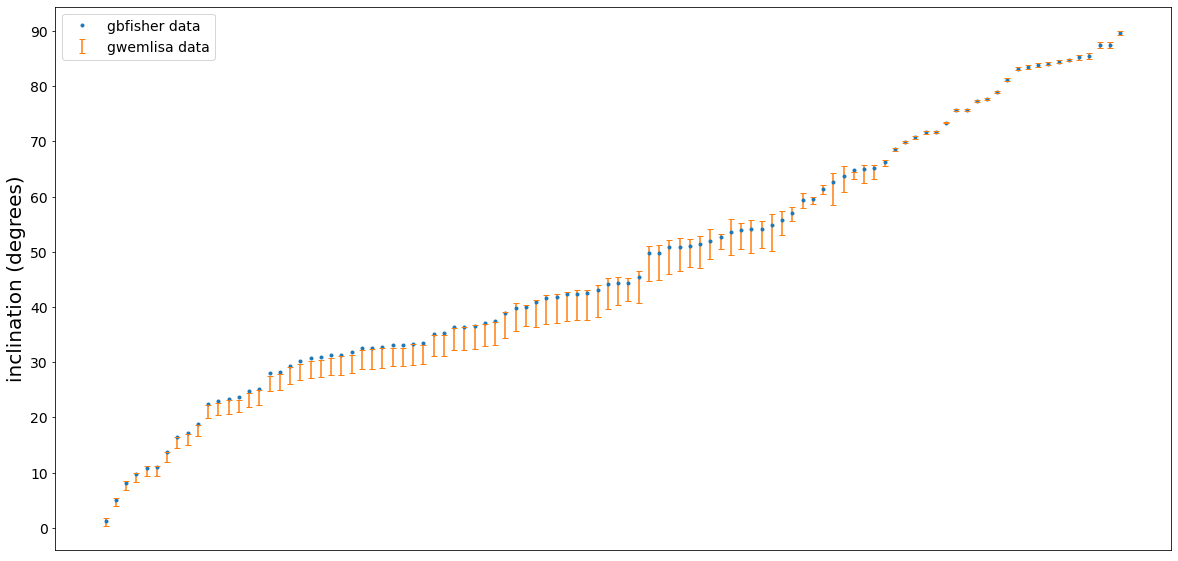

In [6]:
i_gbfisher = gbfisher.sort_values(['inclination']).reset_index()
i_gwemlisa = igwemlisa.sort_values(['i']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.yticks(np.arange(0, 100, 10))
plt.plot(i_gbfisher['inclination'][cut],linestyle='',marker='.')
plt.errorbar(x=range(lb,ub),y=i_gwemlisa['i'][cut],capsize=3,yerr=np.transpose(np.array(i_gwemlisa[['-s_i','+s_i']][cut])),linestyle='',marker='')
plt.ylabel('inclination (degrees)',fontsize=20)
ax.legend(['gbfisher data','gwemlisa data'],fontsize=14)
fig.savefig('inclination_plot.jpg')

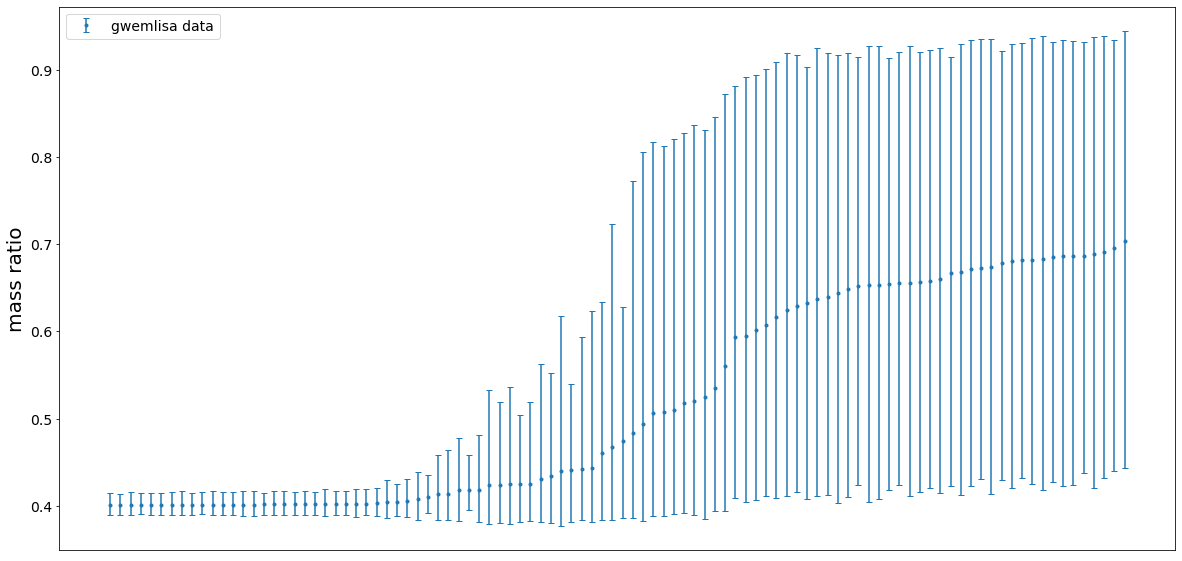

In [21]:
q_gwemlisa = qgwemlisa.sort_values(['q']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.errorbar(x=range(lb,ub),y=q_gwemlisa['q'][cut],capsize=3,yerr=np.transpose(np.array(q_gwemlisa[['-s_q','+s_q']][cut])),linestyle='',marker='.')
ax.legend(['gwemlisa data'],fontsize=14)
plt.ylabel('mass ratio',fontsize=20)
fig.savefig('mass_ratio_plot.jpg')